***Источники данных:***


*   *Средняя зарплата по округам РФ:* https://translated.turbopages.org/proxy_u/en-ru.ru.a50c12cc-6309e9e5-2457430c-74722d776562/https/en.wikipedia.org/wiki/List_of_Russian_federal_subjects_by_average_wage

*   *Средний возраст по округам РФ:* https://миркарт.рф/карты?id=83

*   *Процент урбанизации по округам РФ:* https://миркарт.рф/карты?id=208

*   *Данные о стоимости акций Ростелекома:* https://ru.investing.com/equities/rostelecom-historical-data

*   *Данные по обновлениям World of Tanks:* https://wiki.wargaming.net/ru/Tank:Список_обновлений



#Uploading data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')

In [ ]:
train.shape

(273000, 38)

In [ ]:
train.columns

Index(['label', 'period', 'subject_type', 'subject_name', 'city_name', 'hex',
       'hex_lat', 'hex_lon', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18',
       'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28',
       'f29', 'f30'],
      dtype='object')

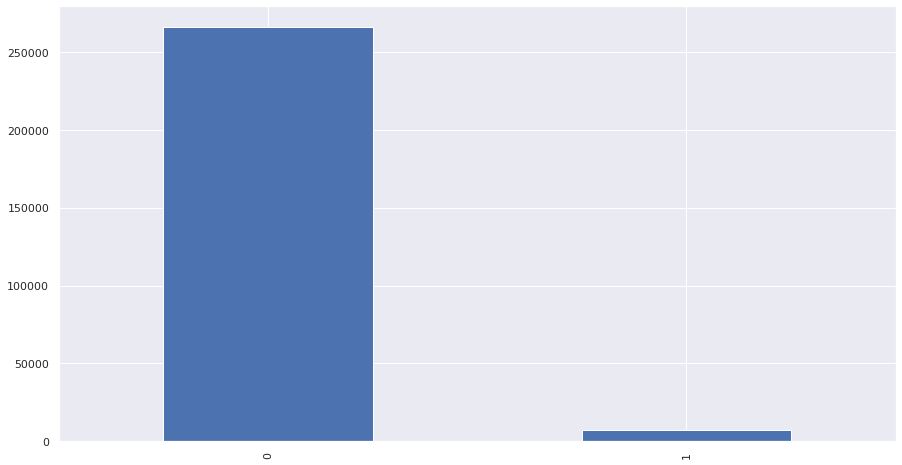

In [ ]:
train.label.value_counts().plot(kind='bar')

#Fill nan values

In [ ]:
train.isnull().sum() #сколько пропущенных значений в каждой колонке

label                0
period               0
subject_type         0
subject_name         0
city_name            9
hex                  0
hex_lat              0
hex_lon              0
f1               33639
f2               29088
f3               26398
f4               14281
f5               14281
f6               10646
f7              138727
f8               13637
f9               13637
f10                  0
f11                  0
f12                  0
f13             122066
f14               6428
f15              16682
f16             134224
f17             138728
f18                116
f19               6179
f20               6179
f21               6179
f22               6179
f23               6179
f24             121516
f25             121516
f26             121516
f27             121516
f28             121516
f29               6179
f30               6179
dtype: int64

In [ ]:
nulls = train.isnull().sum().sort_values(ascending=False) 
nulls[nulls > 1000].index #нахождение признаков с более, чем 1000 пропусков

Index(['f17', 'f7', 'f16', 'f13', 'f24', 'f28', 'f27', 'f26', 'f25', 'f1',
       'f2', 'f3', 'f15', 'f5', 'f4', 'f8', 'f9', 'f6', 'f14', 'f19', 'f30',
       'f22', 'f23', 'f21', 'f29', 'f20'],
      dtype='object')

In [ ]:
to_fill = ['f7', 'f17', 'f16', 'f13', 'f24', 'f28', 'f27', 'f26', 'f25', 'f1',
       'f2', 'f3', 'f15', 'f4', 'f5', 'f8', 'f9', 'f6']
for i in to_fill:
  train[i] = train[i].fillna(0)
  test[i] = test[i].fillna(0)

In [ ]:
test.shape

(152766, 38)

In [ ]:
test.loc[test.f1.isin(['5.9999999999999995e-']), 'f1'] = '5.9999999999999995e-1'

In [ ]:
test['f1'] = np.array(test.f1.values).astype(float)

In [ ]:
train.city_name.mode()

0    Москва
dtype: object

In [ ]:
train = train.fillna({'city_name': 'Москва'}) #заполнение пропусков в признаке "city_name" модой
test = test.fillna({'city_name': 'Москва'})

In [ ]:
nulls = train.isnull().sum().sort_values(ascending=False)
nulls[(nulls < 1000) & (nulls > 0)].index

Index(['f18'], dtype='object')

In [ ]:
to_fill = ['f14', 'f30', 'f23', 'f21', 'f22', 'f29', 'f20', 'f19', 'f18'] 
for i in to_fill: #заполнение пропусков в признаках с количеством пропусков < 1000 медианным значением
  train[i] = train[i].fillna(train[i].median())
  test[i] = test[i].fillna(test[i].median())

#Разбиение множества уникальных значний по группам

In [ ]:
#Чтобы после one-hot encoding не было огромного количества признаков, можно сгруппировать регионы РФ
east = ['Приморский', 'Хабаровский', 'Сахалинская', 'Амурская', 'Камчатский', 'Еврейская', 'Магаданская', 'Забайкальский']

ural = ['Башкортостан', 'Оренбургская', 'Удмуртская', 'Пермский', 'Ханты-Мансийский Автономный Округ - Югра', \
        'Ямало-Ненецкий', 'Курганская', 'Свердловская', 'Челябинская']

siberia = ['Тюменская', 'Красноярский', 'Новосибирская', 'Алтайский', 'Иркутская', 'Кемеровская Область-Кузбасс', \
           'Омская', 'Бурятия', 'Хакасия', 'Томская', 'Тыва', 'Алтай', 'Саха /Якутия/']

north = ['Коми', 'Архангельская', 'Вологодская', 'Мурманская', 'Карелия', 'Санкт-Петербург', 'Ленинградская', \
         'Новгородская', 'Ненецкий', 'Калининградская', 'Псковская']

center = ['Москва', 'Воронежская', 'Тульская', 'Калужская', 'Смоленская', 'Московская', 'Рязанская', 'Тамбовская', \
          'Тверская' 'Владимирская', 'Липецкая', 'Курская', 'Ивановская', 'Ярославская', 'Орловская', 'Белгородская', \
          'Брянская', 'Костромская', 'Мордовия', 'Нижегородская', 'Самарская', 'Чувашская', 'Кировская', 'Саратовская', \
          'Марий Эл', 'Ульяновская', 'Татарстан', 'Пензенская']

south = ['Краснодарский', 'Ростовская', 'Волгоградская', 'Ставропольский', 'Калмыкия', 'Астраханская', 'Адыгея']

caucasus = ['Северная Осетия - Алания', 'Калмыкия', 'Карачаево-Черкесская', 'Кабардино-Балкарская', 'Ингушетия', 'Дагестан']

In [ ]:
train.loc[train['subject_name'].isin(east), 'region'] = 'Восток'
train.loc[train['subject_name'].isin(ural), 'region'] = 'Урал'
train.loc[train['subject_name'].isin(siberia), 'region'] = 'Сибирь'
train.loc[train['subject_name'].isin(north), 'region'] = 'Север'
train.loc[train['subject_name'].isin(center), 'region'] = 'Центр'
train.loc[train['subject_name'].isin(south), 'region'] = 'Юг'
train.loc[train['subject_name'].isin(caucasus), 'region'] = 'Кавказ'

test.loc[test['subject_name'].isin(east), 'region'] = 'Восток'
test.loc[test['subject_name'].isin(ural), 'region'] = 'Урал'
test.loc[test['subject_name'].isin(siberia), 'region'] = 'Сибирь'
test.loc[test['subject_name'].isin(north), 'region'] = 'Север'
test.loc[test['subject_name'].isin(center), 'region'] = 'Центр'
test.loc[test['subject_name'].isin(south), 'region'] = 'Юг'
test.loc[test['subject_name'].isin(caucasus), 'region'] = 'Кавказ'

In [ ]:
#Нет особых отличий между областью, республикой, автономном округом, краем и автономной областью
train.loc[train['subject_type'].isin(['Область', 'Республика', 'Автономный Округ', 'Край', 'Автономная Область']), 'subject_type'] = 'Область'
test.loc[test['subject_type'].isin(['Область', 'Республика', 'Автономный Округ', 'Край', 'Автономная Область']), 'subject_type'] = 'Область'

In [ ]:
#Месяца года можно сгруппировать по времени года
train.loc[train['period'].isin(['2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01']), 'season'] = 'Лето'
train.loc[train['period'].isin(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01']), 'season'] = 'Осень'

test.loc[test['period'].isin(['2021-03-01', '2021-04-01', '2020-05-01', '2021-05-01', '2021-06-01', '2020-06-01', '2020-07-01', '2020-08-01']), 'season'] = 'Лето'
test.loc[test['period'].isin(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01']), 'season'] = 'Осень'

In [ ]:
drop = ['subject_name', 'city_name', 'hex']
train = train.drop(drop, axis=1)
test = test.drop(drop, axis=1)

In [ ]:
train = train.fillna({'region': 'Центр'})
test = test.fillna({'region': 'Центр'})

#New features

[Источник](https://translated.turbopages.org/proxy_u/en-ru.ru.a50c12cc-6309e9e5-2457430c-74722d776562/https/en.wikipedia.org/wiki/List_of_Russian_federal_subjects_by_average_wage)

In [ ]:
train.loc[train['region'] == 'Кавказ', 'mean_s'] = 31_362
train.loc[train['region'] == 'Юг', 'mean_s'] = 35_699
train.loc[train['region'] == 'Центр', 'mean_s'] = 62_400
train.loc[train['region'] == 'Север', 'mean_s'] = 54_543
train.loc[train['region'] == 'Урал', 'mean_s'] = 53_667
train.loc[train['region'] == 'Сибирь', 'mean_s'] = 43_224
train.loc[train['region'] == 'Восток', 'mean_s'] = 58_126

test.loc[test['region'] == 'Кавказ', 'mean_s'] = 31_362
test.loc[test['region'] == 'Юг', 'mean_s'] = 35_699
test.loc[test['region'] == 'Центр', 'mean_s'] = 62_400
test.loc[test['region'] == 'Север', 'mean_s'] = 54_543
test.loc[test['region'] == 'Урал', 'mean_s'] = 53_667
test.loc[test['region'] == 'Сибирь', 'mean_s'] = 43_224
test.loc[test['region'] == 'Восток', 'mean_s'] = 58_126

[Источник](https://миркарт.рф/карты?id=83) 

In [ ]:
train.loc[train['region'] == 'Кавказ', 'mean_age'] = 35.34
train.loc[train['region'] == 'Юг', 'mean_age'] = 40.83
train.loc[train['region'] == 'Центр', 'mean_age'] = 42.01
train.loc[train['region'] == 'Север', 'mean_age'] = 41.15
train.loc[train['region'] == 'Урал', 'mean_age'] = 38.91
train.loc[train['region'] == 'Сибирь', 'mean_age'] = 39.12
train.loc[train['region'] == 'Восток', 'mean_age'] = 37.93

test.loc[test['region'] == 'Кавказ', 'mean_age'] = 35.34
test.loc[test['region'] == 'Юг', 'mean_age'] = 40.83
test.loc[test['region'] == 'Центр', 'mean_age'] = 42.01
test.loc[test['region'] == 'Север', 'mean_age'] = 41.15
test.loc[test['region'] == 'Урал', 'mean_age'] = 38.91
test.loc[test['region'] == 'Сибирь', 'mean_age'] = 39.12
test.loc[test['region'] == 'Восток', 'mean_age'] = 37.93

[Источник](https://ru.investing.com/equities/rostelecom-historical-data)

In [ ]:
rtk = pd.read_csv('Ростелеком.csv')
rtk = rtk.set_index('Дата')
rtk

,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
Дата,,,,,,
01 дек. 2021 г.,"86,63","85,10","90,46","80,06","48,16M","2,16%"
01 нояб. 2021 г.,"84,80","93,06","94,25","84,02","48,78M","-9,06%"
01 окт. 2021 г.,"93,25","90,50","97,40","88,70","45,34M","3,02%"
01 сент. 2021 г.,"90,52","94,30","96,31","90,10","46,17M","-4,01%"
01 авг. 2021 г.,"94,30","93,83","98,43","92,65","44,45M","0,84%"
01 июл. 2021 г.,"93,51","102,24","103,74","91,96","49,68M","-8,32%"
01 июн. 2021 г.,"102,00","103,33","105,37","99,78","41,75M","-1,12%"
01 мая 2021 г.,"103,16","103,60","108,67","101,22","43,61M","-0,81%"
01 апр. 2021 г.,"104,00","107,45","109,28","103,21","43,52M","-3,17%"


In [ ]:
train.loc[train['period'] == '2020-05-01', 'Цена'] = 82.92
train.loc[train['period'] == '2020-06-01', 'Цена'] = 87.70
train.loc[train['period'] == '2020-07-01', 'Цена'] = 89.88
train.loc[train['period'] == '2020-08-01', 'Цена'] = 96.63
train.loc[train['period'] == '2020-09-01', 'Цена'] = 98.41
train.loc[train['period'] == '2020-10-01', 'Цена'] = 92.38
train.loc[train['period'] == '2020-11-01', 'Цена'] = 95.67
train.loc[train['period'] == '2020-12-01', 'Цена'] = 96.52

test.loc[test['period'] == '2020-11-01', 'Цена'] = 95.67
test.loc[test['period'] == '2020-12-01', 'Цена'] = 96.52
test.loc[test['period'] == '2021-01-01', 'Цена'] = 101.03
test.loc[test['period'] == '2021-02-01', 'Цена'] = 108.85
test.loc[test['period'] == '2021-03-01', 'Цена'] = 107.40
test.loc[test['period'] == '2021-04-01', 'Цена'] = 104.00
test.loc[test['period'] == '2021-05-01', 'Цена'] = 103.16
test.loc[test['period'] == '2021-06-01', 'Цена'] = 102.00

[Источник](https://wiki.wargaming.net/ru/Tank:Список_обновлений)

In [ ]:
train.loc[train['period'] == '2020-05-01', 'Обновление'] = 0
train.loc[train['period'] == '2020-06-01', 'Обновление'] = 1
train.loc[train['period'] == '2020-07-01', 'Обновление'] = 0
train.loc[train['period'] == '2020-08-01', 'Обновление'] = 1
train.loc[train['period'] == '2020-09-01', 'Обновление'] = 0
train.loc[train['period'] == '2020-10-01', 'Обновление'] = 1
train.loc[train['period'] == '2020-11-01', 'Обновление'] = 0
train.loc[train['period'] == '2020-12-01', 'Обновление'] = 1

test.loc[test['period'] == '2020-11-01', 'Обновление'] = 0
test.loc[test['period'] == '2020-12-01', 'Обновление'] = 1
test.loc[test['period'] == '2021-01-01', 'Обновление'] = 1
test.loc[test['period'] == '2021-02-01', 'Обновление'] = 0
test.loc[test['period'] == '2021-03-01', 'Обновление'] = 1
test.loc[test['period'] == '2021-04-01', 'Обновление'] = 1
test.loc[test['period'] == '2021-05-01', 'Обновление'] = 0
test.loc[test['period'] == '2021-06-01', 'Обновление'] = 1

In [ ]:
train = train.drop('period', axis=1)
test = test.drop('period', axis=1)

#One-hot encoding

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [ ]:
for feature in ['region', 'season', 'subject_type']:
  train = encode_and_bind(train, feature).drop(feature, axis=1)
  test = encode_and_bind(test, feature).drop(feature, axis=1)

#Кластеризация

In [ ]:
from sklearn.cluster import KMeans
train2 = train.copy(deep=True).drop('label', axis=1)

In [ ]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(train2)

KMeans(n_clusters=2, random_state=42)

In [ ]:
train['Кластер'] =  model.predict(train.drop('label', axis=1))
test['Кластер'] = model.predict(test.drop('label', axis=1))

#Correlation & Feature importance value

##Feature importance value function

In [ ]:
#feature importance value
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 7
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = np.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

##Correlation & Feature importance value

In [ ]:
final_iv, IV = data_vars(train, train.label)
IV.sort_values(by='IV',ascending=False)

,VAR_NAME,IV
3,f12,0.503412
1,f10,0.445090
12,f20,0.391561
22,f3,0.334349
0,f1,0.315965
11,f2,0.314790
13,f21,0.251464
2,f11,0.244660
9,f18,0.207889
36,region_Север,0.184459


In [ ]:
IV[IV.IV == 0.0].VAR_NAME.values

array(['f13', 'f14', 'f16', 'f17', 'f22', 'f23', 'f24', 'f25', 'f26',
       'f27', 'f28', 'f30', 'f4', 'f5', 'f7', 'f8', 'f9'], dtype=object)

In [ ]:
drop = ['f17', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f30',
       'f4', 'f5', 'f7', 'f8', 'f9'] #удаление признаков с нулевым feature importance value
train = train.drop(drop, axis=1)
test = test.drop(drop, axis=1)

In [ ]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

,label,hex_lat,hex_lon,f1,f2,f3,f6,f10,f11,f12,f13,f14,f15,f16,f18,f19,f20,f21,f29,mean_s,mean_age,Цена,Обновление,region_Восток,region_Кавказ,region_Север,region_Сибирь,region_Урал,region_Центр,region_Юг,season_Лето,season_Осень,subject_type_Город,subject_type_Область,Кластер
label,1.000000,0.083306,0.076442,0.073915,0.075815,0.080206,-0.000702,0.116415,0.081608,0.129423,0.001951,-0.001073,-0.003433,0.057257,0.019222,0.041309,0.151741,0.103202,0.019418,-0.009711,-0.032400,-0.025252,-0.065297,0.114905,-0.017706,0.079472,0.041228,-0.023849,-0.062271,-0.033270,-0.018611,0.018611,0.009344,-0.009344,0.001491
hex_lat,0.083306,1.000000,-0.005926,0.015355,0.010996,0.018307,0.224678,0.123429,0.052165,0.138959,-0.007968,-0.013189,0.015686,0.006070,-0.065100,0.057330,0.368911,0.406139,-0.150374,0.492665,0.149371,-0.451878,0.106918,-0.073556,-0.354901,0.547541,-0.013810,0.196196,-0.023815,-0.617645,0.362907,-0.362907,0.202287,-0.202287,-0.572241
hex_lon,0.076442,-0.005926,1.000000,0.031131,0.013864,-0.001949,0.074777,0.114906,0.058362,0.099172,0.009372,-0.004345,0.002271,0.124942,0.070986,0.330466,0.033181,-0.259065,0.107526,-0.325328,-0.609226,0.398268,-0.041819,0.341287,-0.043584,-0.347391,0.739081,0.261878,-0.389103,-0.166372,-0.618775,0.618775,-0.327140,0.327140,0.427019
f1,0.073915,0.015355,0.031131,1.000000,0.968177,0.931207,0.061858,0.127734,0.026309,0.122845,-0.003390,0.002461,-0.002449,0.006603,0.011229,-0.032622,0.027494,0.001515,0.049187,0.001345,-0.005690,-0.058825,-0.063417,0.010684,0.002663,-0.020511,0.038105,-0.018523,0.012158,-0.018494,-0.027115,0.027115,0.081781,-0.081781,0.016627
f2,0.075815,0.010996,0.013864,0.968177,1.000000,0.978051,0.067217,0.131085,0.028758,0.126351,-0.003832,0.002451,-0.000466,0.007525,0.010665,-0.044525,0.029157,-0.000678,0.057600,0.013109,0.012163,-0.081478,-0.069828,0.009511,0.005047,-0.023025,0.026971,-0.033982,0.032339,-0.017943,-0.011454,0.011454,0.100554,-0.100554,0.009392
f3,0.080206,0.018307,-0.001949,0.931207,0.978051,1.000000,0.071019,0.138824,0.030953,0.134693,-0.004278,0.002158,0.000726,0.008499,0.009840,-0.051788,0.034971,0.008855,0.057807,0.022569,0.024394,-0.099011,-0.074173,0.006130,0.005544,-0.012834,0.016231,-0.042260,0.040845,-0.020967,0.001196,-0.001196,0.113342,-0.113342,-0.000740
f6,-0.000702,0.224678,0.074777,0.061858,0.067217,0.071019,1.000000,0.089345,-0.004534,0.083745,-0.004207,0.002029,0.005360,-0.053042,-0.084017,-0.129374,0.018791,-0.096535,0.112459,0.248583,-0.037969,-0.285831,0.182590,-0.026021,-0.115897,-0.153624,-0.053531,0.325002,0.103192,-0.255315,-0.014275,0.014275,0.210330,-0.210330,-0.262272
f10,0.116415,0.123429,0.114906,0.127734,0.131085,0.138824,0.089345,1.000000,0.001462,0.947895,0.007595,0.026061,0.042824,-0.069655,0.040935,0.011606,0.191432,0.175908,-0.023744,-0.094849,-0.137212,0.050772,-0.041694,0.058999,0.029541,0.079490,0.026793,0.090328,-0.168911,0.007579,-0.145362,0.145362,-0.046225,0.046225,0.035834
f11,0.081608,0.052165,0.058362,0.026309,0.028758,0.030953,-0.004534,0.001462,1.000000,0.030265,0.045555,-0.000616,0.001481,0.649112,0.042389,0.156382,0.065771,0.055259,-0.005009,-0.020267,-0.027283,-0.005947,-0.012922,0.036948,-0.031447,0.019525,0.035400,0.016950,-0.047493,-0.001061,-0.046310,0.046310,-0.044420,0.044420,0.015329
f12,0.129423,0.138959,0.099172,0.122845,0.126351,0.134693,0.083745,0.947895,0.030265,1.000000,0.007112,0.024600,0.038970,-0.058422,0.042038,0.009689,0.203656,0.209484,-0.036114,-0.094591,-0.131472,0.037638,-0.060173,0.058823,0.026602,0.113127,0.019021,0.083287,-0.181003,0.006282,-0.134985,0.134985,-0.030559,0.030559,0.028009


In [ ]:
train = train.drop(['f2', 'f3', 'f10', 'subject_type_Область', 'season_Осень'], axis=1) #удаление признаков, которые сильно коррелируют друг с другом. Также удалены "парные" признаки за ненадобностью
test = test.drop(['f2', 'f3', 'f10', 'subject_type_Область', 'season_Осень'], axis=1) 

#Undersampling

In [ ]:
#избавление от дисбаланса целевой переменной при помощи imblearn
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
rus.fit(train.drop('label', axis=1), train.label)
train_resampled, label_resampled = rus.fit_resample(train.drop('label', axis=1), train.label)

In [ ]:
train_resampled['label'] = label_resampled

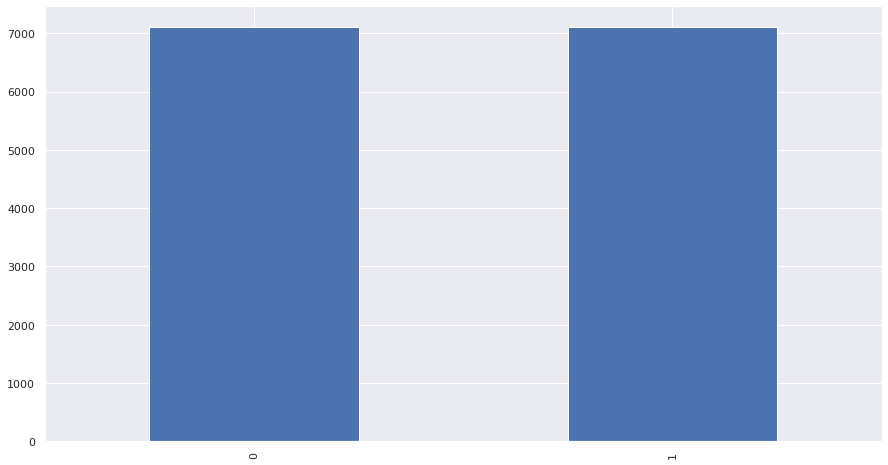

In [ ]:
train_resampled.label.value_counts().plot(kind='bar')

In [ ]:
train2 = train.copy(deep=True)

In [ ]:
train = train_resampled.copy(deep=True)

#CatBoost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
params = {'verbose': 0, 'eval_metric': 'Precision', 'random_state': 42}

In [ ]:
cbc = CatBoostClassifier(**params)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('label', axis=1), train.label, random_state=42, test_size=0.2)

In [ ]:
cbc.fit(X_train, y_train) #обучение модели

In [ ]:
predVal = cbc.predict(test.drop('label', axis=1))

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

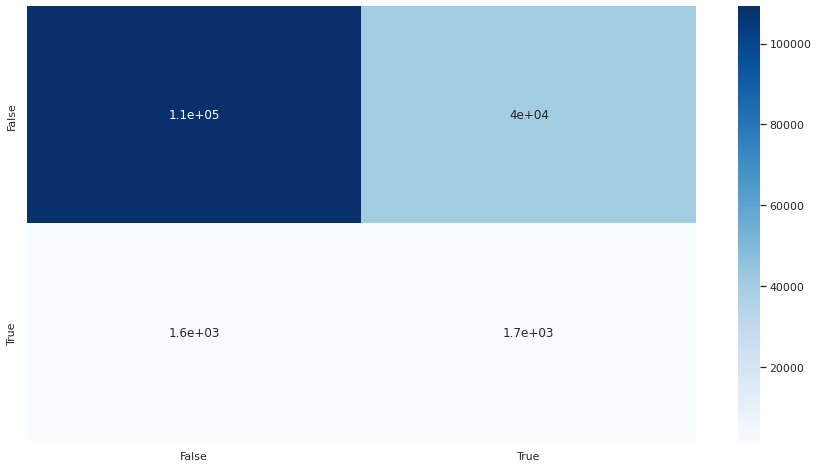

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

ax = sns.heatmap(confusion_matrix(test.label, predVal), annot=True, cmap='Blues')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

In [ ]:
precision_score(test.label, predVal) #значение precision на валидационной выборке

0.04493252505559448

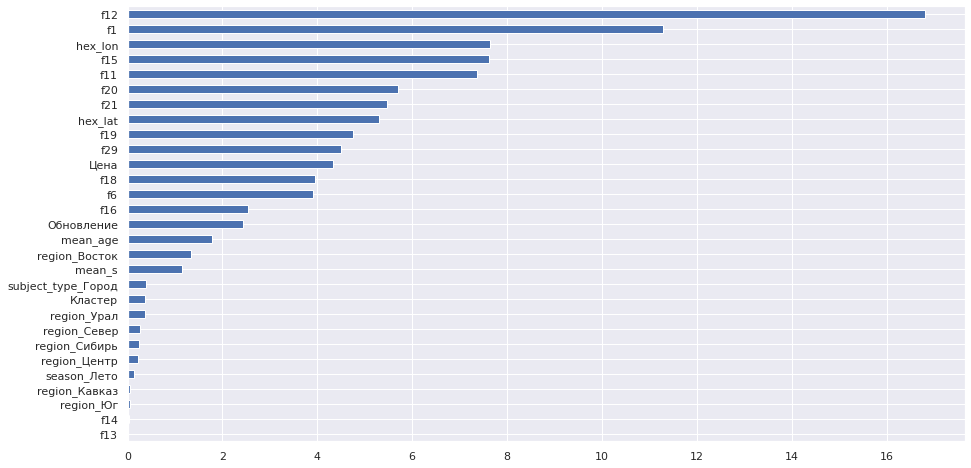

In [ ]:
fiv = pd.Series(cbc.get_feature_importance(), #график важности признаков
                         train.drop(['label'], axis=1).columns)
fiv.sort_values(ascending=True).plot(kind='barh')